In [145]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchview import draw_graph  # attempts to visualize computational graphs
import matplotlib.pyplot as plt
import ffmpeg_quality_metrics as ffqm  # for VMAF calculation
from PIL import Image
import cv2
import os
import random
import subprocess
import json

# pip install ffmpeg_quality_metrics

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


the-pink-panther-1964.mp4
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-pink-panther-1964.mp4
5781
printing frame number: 3269


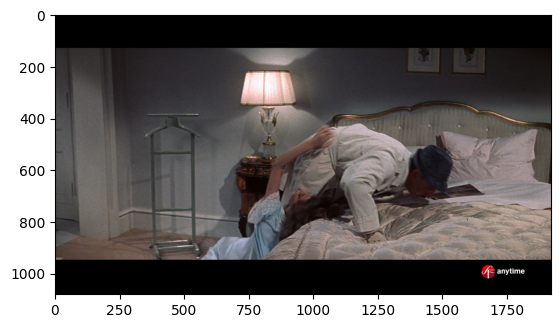

In [140]:
# läs in data och preprocessa

train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train"
random_video = random.choice(os.listdir(train))
print(random_video)

video_path = os.path.join(train, random_video)
print(video_path)

cap = cv2.VideoCapture(video_path)

cap_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap_length)

random_frame = random.randrange(0, cap_length)
print("printing frame number:", random_frame)

cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)

ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # avoid frame becoming blue

if ret:
    plt.imshow(frame_rgb)
    plt.show()
    
cap.release()
cv2.destroyAllWindows()


In [148]:

compression_levels = [0, 23, 50, 75]
results = []

for video in os.listdir(train):
    video_path = os.path.join(train, video)

    original_cap = cv2.VideoCapture(video_path)
    original_frame_count = int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_cap.release()

    original_vmaf_scores = []

    for level in compression_levels:
        compressed_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data", f"compressed_{level}_{video}")
        subprocess.run(["ffmpeg", "-i", video_path, "-c:v", "libx264", "-crf", str(level), compressed_path])

        # Run ffmpeg with libvmaf filter to calculate VMAF
        vmaf_command = [
            "ffmpeg",
            "-i", video_path,
            "-i", compressed_path,
            "-lavfi", f"[0:v][1:v]libvmaf=psnr=1:ssim=1:ms_ssim=1:log_fmt=json:log_path=vmaf_log_{level}.json",
            "-f", "null", "-"
        ]
        subprocess.run(vmaf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

In [ ]:
# Display results for a specific frame in the first video
first_video_results = results[0]
frame_number_to_display = 100

for level, vmaf_scores in zip(first_video_results['compression_levels'], first_video_results['original_vmaf_scores']):
    vmaf_score = vmaf_scores[frame_number_to_display - 1]
    print(f"Frame {frame_number_to_display} - Compression Level {level}:")
    print(f"VMAF Score: {vmaf_score}")

# Clean up the generated JSON log files
for level in compression_levels:
    os.remove(f"vmaf_log_{level}.json")

(1080, 1920, 3)
start row 	-  540
end row 	-  764
start column 	-  540
end column 	-  764
(224, 224, 3)


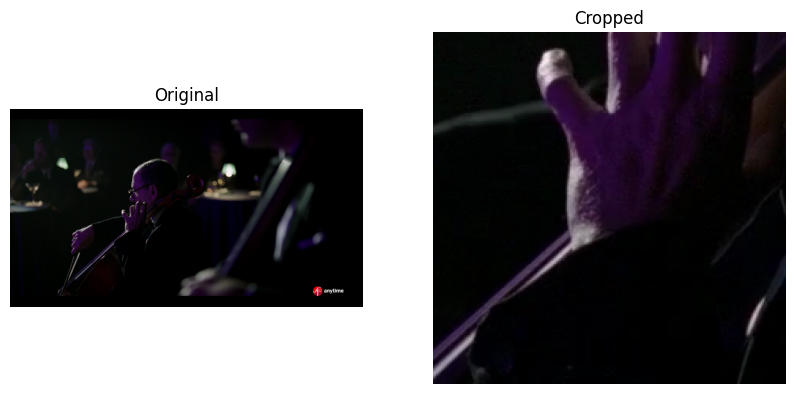

In [131]:
# test-tillämpning av crop

image_shape = frame_rgb.shape

print(frame_rgb.shape)

# cropped_pieces = []

# imgwidth = frame_rgb.shape[0]
# imgheight = frame_rgb.shape[1]

length = 224
width = 224

start_row = 540
start_column = start_row

end_row = length + start_row

end_column = width + start_column

print("start row \t- ", start_row)
print("end row \t- ", end_row)
print("start column \t- ", start_column)
print("end column \t- ", end_column)

image_cropped = frame_rgb[start_row:end_row, start_column:end_column]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

ax1.axis("off")
ax1.title.set_text('Original')

ax2.axis("off")
ax2.title.set_text("Cropped")

ax1.imshow(frame_rgb)
ax2.imshow(image_cropped)

print(image_cropped.shape)     # (224, 224, 3)


In [128]:
# shell command, måste på nåt sätt se till att "mappa" till rätt video
import subprocess

output_video = 'compressed_data/output_video.mp4'

ffmpeg_command = f'ffmpeg -i {str(random_video)} -c:v libx264 -crf 23 -preset medium -c:a aac -b:a 128k {output_video}'

subprocess.run(ffmpeg_command, shell=True)

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

CompletedProcess(args='ffmpeg -i the-promotion.mp4 -c:v libx264 -crf 23 -preset medium -c:a aac -b:a 128k compressed_data/output_video.mp4', returncode=1)

In [ ]:
"""
model.eval() is a kind of switch for some specific layers/parts of the model that behave differently 
during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
You need to turn them off during model evaluation, and .eval() will do it for you.
In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation:
"""

model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.eval()    # BUT, don't forget to turn back to training mode after eval step: model.train()